# Predicting age by photo

<b>Task:</b> To build a model for predicting age by photo. RESNET50 is used as a model

In [2]:
import os
import random

import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

## Exploratory data analysis

In [3]:
labels = pd.read_csv('datasets/faces/labels.csv')

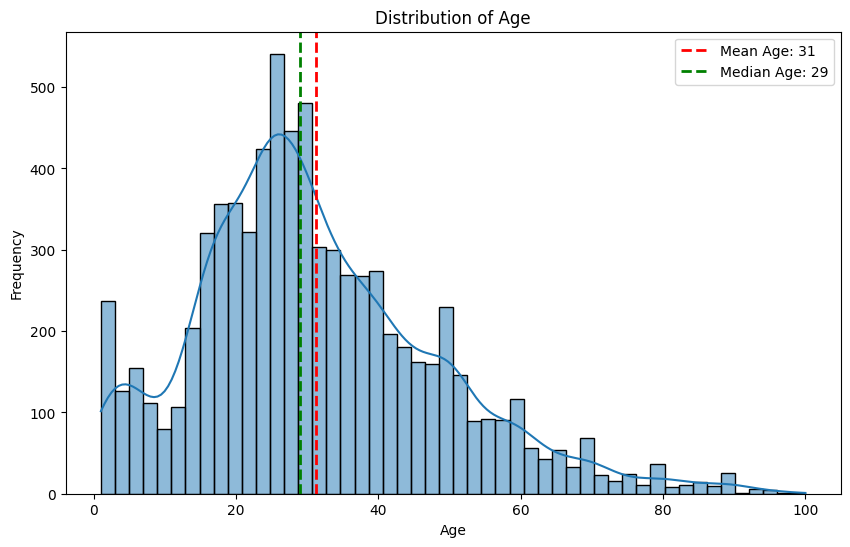

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data=labels['real_age'], bins=50, kde=True)

mean_age = labels['real_age'].mean()
median_age = labels['real_age'].median()

plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean Age: {mean_age:.0f}')
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median Age: {median_age:.0f}')

plt.legend()
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Training

In [11]:
EPOCH_NUM = 10
DEVICE='cuda:0' if torch.cuda.is_available() else 'cpu'
LR = 1e-4
BATCH_SIZE = 32
WEIGHT_DECAY = 0.05

In [12]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [14]:
train_data, val_data = train_test_split(labels, test_size=0.25, random_state=12345)

train_dataset = CustomDataset(dataframe=train_data, root_dir='datasets/faces/final_files', transform=transform)
val_dataset = CustomDataset(dataframe=val_data, root_dir='datasets/faces/final_files', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(
        in_features=model.fc.in_features,
        out_features=1
    )  

model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

In [18]:
best_val_loss = float('inf')

for epoch in trange(EPOCH_NUM):
    model.train()
    train_loss = 0.0
    for i,(images, labels) in tqdm(enumerate(train_loader)):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())  
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        
        if i%BATCH_SIZE==0:
            print('step', i, 'Training Loss', train_loss/(i+1))

        
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())  
            val_loss += loss.item()
            
    
    print('Epoch {}/{},  Training Loss: {:.2f},  Validation Loss: {:.2f}'.format(
        epoch+1, EPOCH_NUM , train_loss/len(train_loader), val_loss/len(val_loader)))
    if (val_loss/len(val_loader))<best_val_loss:
        best_val_loss = val_loss/len(val_loader)
        torch.save(model.state_dict(), 'models/model_cv_age/model_cv_age.pth')
        print('Saving best model...')

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

step 0 Training Loss 1296.540771484375
step 32 Training Loss 1154.7821229876895
step 64 Training Loss 909.2769643930288
step 96 Training Loss 767.3047227367913
step 128 Training Loss 660.2227576204049
step 160 Training Loss 579.7069182307083
Epoch 1/10,  Training Loss: 543.16,  Validation Loss: 170.73
Saving best model...


0it [00:00, ?it/s]

step 0 Training Loss 226.79598999023438
step 32 Training Loss 130.2925031257398
step 64 Training Loss 116.60686733539288
step 96 Training Loss 106.80361706448585
step 128 Training Loss 103.9772062079851
step 160 Training Loss 96.44372132105858
Epoch 2/10,  Training Loss: 94.66,  Validation Loss: 90.62
Saving best model...


0it [00:00, ?it/s]

step 0 Training Loss 38.65150451660156
step 32 Training Loss 44.379932865952
step 64 Training Loss 47.92782959571252
step 96 Training Loss 47.35628920486293
step 128 Training Loss 47.43348778125851
step 160 Training Loss 46.04204979890622
Epoch 3/10,  Training Loss: 45.29,  Validation Loss: 88.17
Saving best model...


0it [00:00, ?it/s]

step 0 Training Loss 21.276039123535156
step 32 Training Loss 33.175036603754215
step 64 Training Loss 29.79575711763822
step 96 Training Loss 28.715004399879692
step 128 Training Loss 29.093458700549697
step 160 Training Loss 30.72502833419705
Epoch 4/10,  Training Loss: 30.53,  Validation Loss: 74.68
Saving best model...


0it [00:00, ?it/s]

step 0 Training Loss 15.382159233093262
step 32 Training Loss 22.336824373765424
step 64 Training Loss 24.013385897416335
step 96 Training Loss 24.686042751233604
step 128 Training Loss 23.92641880345899
step 160 Training Loss 24.13450174153962
Epoch 5/10,  Training Loss: 24.53,  Validation Loss: 77.18


0it [00:00, ?it/s]

step 0 Training Loss 8.891744613647461
step 32 Training Loss 24.68969830599698
step 64 Training Loss 24.193452174846943
step 96 Training Loss 21.72345696282141
step 128 Training Loss 21.004439257836157
step 160 Training Loss 20.228101215007143
Epoch 6/10,  Training Loss: 19.80,  Validation Loss: 71.74
Saving best model...


0it [00:00, ?it/s]

step 0 Training Loss 20.28597640991211
step 32 Training Loss 16.38719620849147
step 64 Training Loss 16.426418414482704
step 96 Training Loss 15.589795845071064
step 128 Training Loss 15.238821905712749
step 160 Training Loss 15.634003461517903
Epoch 7/10,  Training Loss: 15.54,  Validation Loss: 68.49
Saving best model...


0it [00:00, ?it/s]

step 0 Training Loss 11.68954849243164
step 32 Training Loss 12.96864085486441
step 64 Training Loss 15.985718811475314
step 96 Training Loss 15.084296804113487
step 128 Training Loss 14.984352017557898
step 160 Training Loss 14.830394482760695
Epoch 8/10,  Training Loss: 14.87,  Validation Loss: 68.99


0it [00:00, ?it/s]

step 0 Training Loss 5.707965850830078
step 32 Training Loss 14.958616776899857
step 64 Training Loss 17.494806465735802
step 96 Training Loss 15.927816582709244
step 128 Training Loss 14.727173199025236
step 160 Training Loss 15.071043523942462
Epoch 9/10,  Training Loss: 15.03,  Validation Loss: 76.07


0it [00:00, ?it/s]

step 0 Training Loss 13.040427207946777
step 32 Training Loss 15.684750744790742
step 64 Training Loss 14.40405529829172
step 96 Training Loss 14.69347321864256
step 128 Training Loss 14.830305687216825
step 160 Training Loss 14.662836815259471
Epoch 10/10,  Training Loss: 14.92,  Validation Loss: 84.69
